In [ ]:
%tensorflow_version 2.x
!nvidia-smi
%pip install -q transformers

Thu Dec 10 04:46:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
from transformers import TFBertModel
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Loading data
train = pd.read_csv("07-train.csv", encoding = "utf-8-sig")
valid = pd.read_csv("07-test.csv", encoding = "utf-8-sig")

In [ ]:
train["words"] = train["words"].str.replace("¿","")
train["words"] = train["words"].str.replace("?","")
valid["words"] = valid["words"].str.replace("¿","")
valid["words"] = valid["words"].str.replace("?","")

In [ ]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

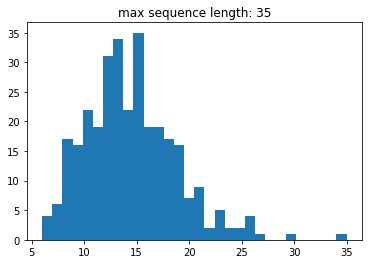

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in train["words"]]
max_seq_len = max(train_sequence_lengths)
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max_seq_len}");

In [ ]:
intent_names = train["intent"].unique() 
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
slot_names = ["[PAD]"]
slot_names += ["B-crop","B-cultivar","I-cultivar","B-locality","I-locality","B-measure","I-measure","B-date","I-date","B-unit","I-unit","O"]
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)

In [ ]:
print(intent_map)
print(slot_map)

{'forecast_yield': 0, 'forecast_precipitation': 1, 'climatology': 2, 'cultivars': 3, 'places': 4, 'forecast_date': 5}
{'[PAD]': 0, 'B-crop': 1, 'B-cultivar': 2, 'I-cultivar': 3, 'B-locality': 4, 'I-locality': 5, 'B-measure': 6, 'I-measure': 7, 'B-date': 8, 'I-date': 9, 'B-unit': 10, 'I-unit': 11, 'O': 12}


In [ ]:
def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

In [ ]:
encoded_train = encode_dataset(tokenizer, train["words"], max_seq_len)
encoded_valid = encode_dataset(tokenizer, valid["words"], max_seq_len)

In [ ]:
# print(encoded_train["input_ids"])
# print(encoded_train["attention_masks"])
# print(encoded_valid["input_ids"])
# print(encoded_valid["attention_masks"])

In [ ]:
intent_train = train["intent"].map(intent_map).values
intent_valid = valid["intent"].map(intent_map).values

In [ ]:
print(intent_train)
print(intent_valid)

[0 1 2 1 3 0 3 1 4 0 2 0 3 3 4 1 3 0 0 3 1 1 2 5 3 0 5 3 1 4 0 4 3 2 1 5 5
 2 5 3 3 3 0 1 1 1 0 3 4 1 1 5 5 5 4 3 4 3 5 2 3 3 5 1 0 1 3 5 0 0 0 0 4 4
 3 1 3 0 1 1 0 4 5 1 5 1 3 3 4 5 3 4 0 1 0 3 1 4 3 3 4 2 1 1 2 0 1 4 4 4 0
 4 1 0 3 0 0 3 3 5 0 1 5 1 4 4 5 0 4 1 3 1 5 4 1 4 1 4 5 1 1 2 1 0 1 1 1 1
 3 5 1 5 2 2 3 3 0 1 1 2 4 0 4 2 4 1 2 5 0 1 0 1 5 2 0 3 0 1 4 4 1 2 5 0 1
 5 4 1 3 0 2 2 1 5 3 5 2 1 2 4 0 3 4 4 2 4 4 5 1 5 2 4 5 3 4 0 4 5 0 0 2 5
 3 0 1 4 1 4 2 2 2 4 4 0 2 4 1 4 1 3 4 0 4 4 3 2 2 2 5 2 5 0 0 2 2 3 5 3 5
 2 0 5 3 5 2 5 2 0 3 5 1 1 2 3 0 5 0 5 1 5 0 1 3 2 0 3 3 4 1 4 2 1 3 0 0 4
 2 5 2 0 3 4 5 4 5 5 3 3 2 1 3]
[3 5 3 0 5 5 1 0 2 1 4 2 0 0 0 1 0 2 1 5 5 1 4 1 5 5 1 0 2 1 0 4 0 2 0 2 3
 2 0 1 1 4 1 4 1 5 5 2 0 4 0 1 2 4 2 5 5 0 4 3 1 0 1 3 3 4 1 3 2 2 0 5 3 3
 1 5 2 2 5 1 3 0 3 5 3 5 0 3 5 5 4 5 3 2 1 0 4 1 0 2 2 0 0 4 3 1 5 2 5 2 0
 1 5 1 3 2 3 5 2 5 1 3 4 4 4 5 4 1 2 4 3 0 0 1]


In [ ]:
slot_train = encode_token_labels(train["words"], train["labels"], tokenizer, slot_map, max_seq_len)
slot_valid = encode_token_labels(valid["words"], valid["labels"], tokenizer, slot_map, max_seq_len)

In [ ]:
print(encoded_train["attention_masks"][10])
print(slot_train[10])
#print(slot_valid)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 12 12 12 12 12 12 12  6  7  7 12 12 12 12  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
base_bert_model = TFBertModel.from_pretrained(model_name)
base_bert_model.summary()
outputs = base_bert_model(encoded_valid)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  177853440 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(outputs)
# The first ouput of the BERT model is a tensor with shape: (batch_size, seq_len, output_dim) 
# which computes features for each token in the input sequence:
print(outputs[0].shape)
# The second output of the BERT model is a tensor with shape (batch_size, output_dim) 
# which is the vector representation of the special token [CLS]. 
# This vector is typically used as a pooled representation for the sequence as a whole. 
# This is will be used as the features of our Intent classifier:
print(outputs[1].shape)

(134, 35, 768)
(134, 768)


In [ ]:
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None, dropout_prob=0.1):        
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name).bert
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       activation='softmax',
                                       name="intent_classifier")
        
        self.slot_classifier = Dense(slot_num_labels,
                                     activation='softmax',
                                     name="slot_classifier")

    def call(self, inputs, **kwargs):   
        
        features = self.bert(inputs, **kwargs)        
        sequence_output = features[0]
        pooled_output = features[1]

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output, training=kwargs.get("training", False))
        #sequence_output = self.dropout(sequence_output)
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        #pooled_output = self.dropout(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits


In [ ]:
def create_model(intent_num_labels, slot_num_labels):
  
  model_inputs =  keras.layers.Input(shape=(None,), dtype='int32', name='input_layer')
  
  bert = TFBertModel.from_pretrained(model_name) # get features
  bert_output = bert(model_inputs)    
  
    
  intents_drop = Dropout(rate=0.1, name="intent_dropout")(bert_output[1])  
  intents_fc = Dense(intent_num_labels, activation='softmax', name='intent_classifier')(intents_drop)
  
  slots_output = Dropout(rate=0.3, name='slots_dropout')(bert_output[0])
  slots_output = Dense(500, activation='relu', name='slots_dense')(slots_output)  
  slots_output = Dense(slot_num_labels, activation='softmax', name='slots_classifier')(slots_output)

  model = keras.Model(inputs=model_inputs, outputs=[slots_output, intents_fc])
  return model

In [ ]:
#model2 = JointIntentAndSlotFillingModel(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))
model2 = create_model(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#opt = Adam()#learning_rate=3e-5, epsilon=1e-08)
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=False),
          SparseCategoricalCrossentropy(from_logits=False)]
metrics = [SparseCategoricalAccuracy('accuracy')]
#model.compile(optimizer=opt, loss=losses, metrics=metrics)
model2.compile(optimizer=opt, loss=losses, metrics=metrics)


In [ ]:
!rm -dfr log/

In [ ]:
log_dir = "log/demeter/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

#history = model.fit(
history = model2.fit(    
    x = [encoded_train["input_ids"],encoded_train["attention_masks"]],
    y = (slot_train, intent_train),
    validation_split=0.2,
    batch_size=90,
    shuffle=True,
    epochs=40,
    callbacks=[tensorboard_callback]
    )

Epoch 1/40
3/3 [==============================] - 4s 1s/step - loss: 3.3883 - slots_classifier_loss: 1.5453 - intent_classifier_loss: 1.8430 - slots_classifier_accuracy: 0.4621 - intent_classifier_accuracy: 0.2056 - val_loss: 2.6766 - val_slots_classifier_loss: 0.7115 - val_intent_classifier_loss: 1.9650 - val_slots_classifier_accuracy: 0.7728 - val_intent_classifier_accuracy: 0.1111
Epoch 2/40
3/3 [==============================] - 1s 429ms/step - loss: 2.4755 - slots_classifier_loss: 0.6614 - intent_classifier_loss: 1.8141 - slots_classifier_accuracy: 0.8276 - intent_classifier_accuracy: 0.2177 - val_loss: 2.3108 - val_slots_classifier_loss: 0.4196 - val_intent_classifier_loss: 1.8912 - val_slots_classifier_accuracy: 0.9197 - val_intent_classifier_accuracy: 0.1111
Epoch 3/40
3/3 [==============================] - 1s 435ms/step - loss: 2.3001 - slots_classifier_loss: 0.4888 - intent_classifier_loss: 1.8113 - slots_classifier_accuracy: 0.9071 - intent_classifier_accuracy: 0.2258 - val_

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log

In [ ]:
model2.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 177853440   input_layer[0][0]                
__________________________________________________________________________________________________
slots_dropout (Dropout)         (None, None, 768)    0           tf_bert_model_1[0][0]            
__________________________________________________________________________________________________
slots_dense (Dense)             (None, None, 500)    384500      slots_dropout[0][0]              
_______________________________________________________________________________________

In [ ]:
tf.saved_model.save(model2, 'demeter_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: demeter_model/assets


In [ ]:
!zip -r demeter_model.zip demeter_model

  adding: demeter_model/ (stored 0%)
  adding: demeter_model/assets/ (stored 0%)
  adding: demeter_model/saved_model.pb (deflated 92%)
  adding: demeter_model/variables/ (stored 0%)
  adding: demeter_model/variables/variables.data-00000-of-00001 (deflated 39%)
  adding: demeter_model/variables/variables.index (deflated 80%)


In [ ]:
from google.colab import files
files.download('demeter_model.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#_, train_acc = model.evaluate([encoded_train["input_ids"],encoded_train["attention_masks"]], (slot_train, intent_train))
#_, test_acc = model.evaluate([encoded_valid["input_ids"],encoded_valid["attention_masks"]], (slot_valid, intent_valid))


train_e = model2.evaluate([encoded_train["input_ids"],encoded_train["attention_masks"]], (slot_train, intent_train))
test_e = model2.evaluate([encoded_valid["input_ids"],encoded_valid["attention_masks"]], (slot_valid, intent_valid))

#train_e = model.evaluate([encoded_train["input_ids"],encoded_train["attention_masks"]], (slot_train, intent_train))
#test_e = model.evaluate([encoded_valid["input_ids"],encoded_valid["attention_masks"]], (slot_valid, intent_valid))

#print("train acc", train_acc)
#print("test acc", test_acc)

5/5 [==============================] - 0s 60ms/step - loss: 1.0143 - slots_classifier_loss: 0.1021 - intent_classifier_loss: 0.9123 - slots_classifier_accuracy: 0.9748 - intent_classifier_accuracy: 0.7836


In [ ]:
y_pred = model2.predict([encoded_valid["input_ids"], encoded_valid["attention_masks"]])#.argmax(axis=-1)
#y_pred = model.predict([encoded_valid["input_ids"], encoded_valid["attention_masks"]])#.argmax(axis=-1)

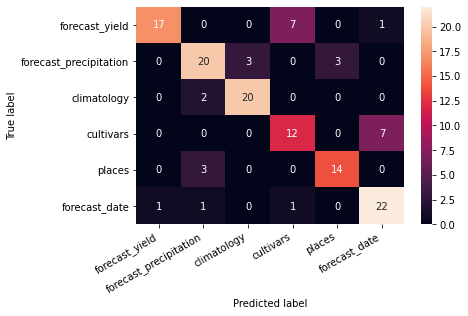

In [ ]:
y_intent = y_pred[1].argmax(axis=-1)
cm = confusion_matrix(intent_valid, y_intent)
df_cm = pd.DataFrame(cm, index=intent_map, columns=intent_map)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
from google.colab import files
#files.download('demeter_m.zip') 

In [ ]:
def show_predictions(text, tokenizer, my_model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = my_model(inputs)
    slot_probs, intent_probs = outputs    
    slot_ids = slot_probs.numpy().argmax(axis=-1)[0, 1:-1]    
    intent_id = intent_probs.numpy().argmax(axis=-1)[0]    
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

show_predictions("Cúal es el mejor tiempo para sembrar en papa en Ibague", tokenizer, model2, intent_names, slot_names)

## Intent: forecast_date
## Slots:
         C : O
      ##úa : B-crop
       ##l : B-crop
        es : O
        el : O
     mejor : O
    tiempo : O
      para : O
    sembra : O
       ##r : O
        en : O
      papa : B-crop
        en : O
         I : B-locality
      ##ba : I-locality
     ##gue : I-locality


In [ ]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [ ]:
def nlu(text, tokenizer, my_model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = my_model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

nlu("Cúal es la climatologia de temperatura máxima en Ibague",tokenizer, model2, intent_names, slot_names)

{'intent': 'climatology', 'slots': {'locality': 'Ibague'}}

In [ ]:
tf.saved_model.save(model2, 'demeter_model')
from google.colab import files
files.download('demeter_m.zip') 
!zip -r demeter_m.zip demeter_m

INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
model_loaded = tf.saved_model.load("demeter_model")

In [ ]:
show_predictions("Cúal es el mejor tiempo para sembrar arroz en Cali", tokenizer, model_loaded, intent_names, slot_names)

## Intent: forecast_date
## Slots:
         C : B-locality
      ##úa : I-cultivar
       ##l : I-cultivar
        es : O
        el : O
     mejor : O
    tiempo : O
      para : O
    sembra : O
       ##r : O
     arroz : B-crop
        en : O
      Cali : B-locality


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, google-pasta, wrapt, grpcio, tensorflow-estimator, absl-py, keras-preprocessing, termcolor, wheel, opt-einsum, protobuf, astunparse, h5py, gast, numpy, six, tensorboard
Required-by: fancyimpute


In [ ]:
!pip freeze > requirements.txt